## Import Libraries and Layers

In [209]:
from IPython.display import display
import arcgis
from arcgis.gis import GIS
import pandas as pd
pd.set_option('display.max_columns', 500)
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [210]:
gis = GIS("https://datascienceqa.esri.com/portal", "portaladmin", "esri.agp", verify_cert=False)
# gis = GIS("https://datascienceqa.esri.com/portal", "portaladmin", "esri.agp")

In [214]:
# Layers Used
# Provider data layer
provider_layer = FeatureLayer("https://datascienceqa.esri.com/server/rest/services/Hosted/provider_clean_data_geocoded_6_19/FeatureServer/0")

# Population Density
from arcgis.mapping import MapImageLayer
popdensity = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Median Income
medIncome = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Median Age
medAge = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/e2558ac0c5e04235ad7820773e89d110/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Health Insurance Coverage
tx_insurance_state = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer")
tx_insurance_county = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer/1")
tx_insurance_tract = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer/2")

# Fertility layers for State, County and Tract (Percent of women 15 to 50 who had a birth in the past 12 months)
fertility_state = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/0")
fertility_county = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/1")
fertility_tract = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/2")

## OBGYN Providers and Other Data

#### Create df for OBGYN providers

In [291]:
# Get provider data for obgyn providers only

obgyn_featureset = provider_layer.query(where="user_taxonomy_code_1 in ['207V00000X','207VC0200X','207VF0040X','207VX0201X','207VG0400X','207VH0002X','207VM0101X','207VB0002X','207VX0000X','207VE0102X','363LX0001X']", out_fields='user_npi,user_entity_type,user_provider_gender,user_taxonomy_code_1,user_full_address,Postal,City,Subregion,Region,RegionAbbr')
obgyn_df = obgyn_featureset.sdf

In [216]:
obgyn_df.head()

,City,OBJECTID,Postal,Region,RegionAbbr,SHAPE,Subregion,user_entity_type,user_full_address,user_npi,user_provider_gender,user_taxonomy_code_1
0,Norman,54,73072,Oklahoma,OK,"{""x"": -97.49116252599998, ""y"": 35.261905469000...",Cleveland County,Individual,"3400 W TECUMSEH RD, SUITE 205, NORMAN, OK 7307...",1487657532,F,207V00000X
1,Sunnyside,70,98944,Washington,WA,"{""x"": -120.00990533799995, ""y"": 46.31641132900...",Yakima County,Individual,"803 E LINCOLN AVE, , SUNNYSIDE, WA 989442383",1265435218,F,207V00000X
2,Charleston,72,25302,West Virginia,WV,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Kanawha County,Individual,"830 PENNSYLVANIA AVE, SUITE 108, CHARLESTON, W...",1447253497,M,207V00000X
3,Charleston,145,25302,West Virginia,WV,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Kanawha County,Individual,"830 PENNSYLVANIA AVE, STE 402, CHARLESTON, WV ...",1487657631,M,207V00000X
4,Charleston,218,25302,West Virginia,WV,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Kanawha County,Individual,"830 PENNSYLVANIA AVE, STE 402, CHARLESTON, WV ...",1255334405,M,207V00000X


In [307]:
obgyn_df.shape

(66754, 12)

In [324]:
obgyn_county_df = obgyn_df[['RegionAbbr','Subregion']]
obgyn_county_df['Provider_Count'] = obgyn_county_df.groupby(['RegionAbbr','Subregion'])['Subregion'].transform('count')
obgyn_count_df = obgyn_county_df.drop_duplicates(subset='Subregion', keep="first", inplace=True)
obgyn_county_df.shape

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(1269, 3)

In [326]:
obgyn_county_df = obgyn_county_df.sort_values(by=['Provider_Count'], ascending=False)
obgyn_county_df.head()

,RegionAbbr,Subregion,Provider_Count
85,CA,Los Angeles County,2058
34,IL,Cook County,1581
1228,NY,New York County,1124
69,TX,Harris County,1111
122,AZ,Maricopa County,828


In [366]:
# Check missing
obgyn_county_df.isnull().sum()

RegionAbbr        0
Subregion         0
Provider_Count    0
dtype: int64

#### Create df for Data from State Layer

In [258]:
county_layer = FeatureLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/46")
county_df = pd.DataFrame()
offset = 0
while offset <= 3000:
    county_featureset_test = county_layer.query(return_all_records=False,
                                           result_offset=offset,
                                           result_record_count=750)
    county_df_test = county_featureset_test.sdf
    county_df = pd.concat([county_df_test, county_df], ignore_index=True)
    offset += 750

In [259]:
county_df.shape

(3142, 1943)

In [42]:
for field in state_layer.properties.fields:
#     print(field)
    print(field['name'], '\t', field['alias'])
#     print(field[0])

OBJECTID 	 OBJECTID
Shape 	 Shape
ID 	 ID
NAME 	 NAME
STATE_NAME 	 STATE_NAME
ST_ABBREV 	 ST_ABBREV
AREA 	 Area in Square Miles (Calculated)
TOTPOP_CY 	 2018 Total Population (Esri)
HHPOP_CY 	 2018 Household Population (Esri)
FAMPOP_CY 	 2018 Family Population (Esri)
GQPOP_CY 	 2018 Group Quarters Population (Esri)
POPDENS_CY 	 2018 Population Density (Pop per Square Mile) (Esri)
TOTHH_CY 	 2018 Total Households (Esri)
AVGHHSZ_CY 	 2018 Average Household Size (Esri)
FAMHH_CY 	 2018 Total Family Households (Esri)
AVGFMSZ_CY 	 2018 Average Family Size (Esri)
TOTHU_CY 	 2018 Total Housing Units (Esri)
OWNER_CY 	 2018 Owner Occupied Housing Units (Esri)
RENTER_CY 	 2018 Renter Occupied Housing Units (Esri)
VACANT_CY 	 2018 Vacant Housing Units (Esri)
POPGRW10CY 	 2010-2018 Population: Annual Growth Rate (Esri)
HHGRW10CY 	 2010-2018 Households: Annual Growth Rate (Esri)
FAMGRW10CY 	 2010-2018 Families: Annual Growth Rate (Esri)
GENALPHACY 	 2018 Generation Alpha Population (Born 2017 or Lat

AGE64_FY 	 2023 Total Population Age 64 (Esri)
AGE65_FY 	 2023 Total Population Age 65 (Esri)
AGE66_FY 	 2023 Total Population Age 66 (Esri)
AGE67_FY 	 2023 Total Population Age 67 (Esri)
AGE68_FY 	 2023 Total Population Age 68 (Esri)
AGE69_FY 	 2023 Total Population Age 69 (Esri)
AGE70_FY 	 2023 Total Population Age 70 (Esri)
AGE71_FY 	 2023 Total Population Age 71 (Esri)
AGE72_FY 	 2023 Total Population Age 72 (Esri)
AGE73_FY 	 2023 Total Population Age 73 (Esri)
AGE74_FY 	 2023 Total Population Age 74 (Esri)
AGE75_FY 	 2023 Total Population Age 75 (Esri)
AGE76_FY 	 2023 Total Population Age 76 (Esri)
AGE77_FY 	 2023 Total Population Age 77 (Esri)
AGE78_FY 	 2023 Total Population Age 78 (Esri)
AGE79_FY 	 2023 Total Population Age 79 (Esri)
AGE80_FY 	 2023 Total Population Age 80 (Esri)
AGE81_FY 	 2023 Total Population Age 81 (Esri)
AGE82_FY 	 2023 Total Population Age 82 (Esri)
AGE83_FY 	 2023 Total Population Age 83 (Esri)
AGE84_FY 	 2023 Total Population Age 84 (Esri)
MAGE0_FY 	 20

OWNER00 	 2000 Owner Occupied Housing Units (U.S. Census)
RENTER00 	 2000 Renter Occupied Housing Units (U.S. Census)
TSEGNUM 	 2018 Dominant Tapestry Number (Esri)
TSEGCODE 	 2018 Dominant Tapestry Segment (Esri)
TSEGNAME 	 2018 Dominant Tapestry Segment Name (Esri)
THHBASE 	 2018 Base for Tapestry Segmentation Households (Esri)
THH01 	 2018 Top Tier (1A) Tapestry Households (Esri)
THH02 	 2018 Professional Pride (1B) Tapestry Households (Esri)
THH03 	 2018 Boomburbs (1C) Tapestry Households (Esri)
THH04 	 2018 Savvy Suburbanites (1D) Tapestry Households (Esri)
THH05 	 2018 Exurbanites (1E) Tapestry Households (Esri)
THH06 	 2018 Urban Chic (2A) Tapestry Households (Esri)
THH07 	 2018 Pleasantville (2B) Tapestry Households (Esri)
THH08 	 2018 Pacific Heights (2C) Tapestry Households (Esri)
THH09 	 2018 Enterprising Professionals (2D) Tapestry Households (Esri)
THH10 	 2018 Laptops and Lattes (3A) Tapestry Households (Esri)
THH11 	 2018 Metro Renters (3B) Tapestry Households (Esri)
THH

In [260]:
# Removing columns for 2023,2010,2000
county_df = county_df.loc[:,~county_df.columns.str.contains('FY|10|00')]
len(county_df.columns)

894

In [261]:
# Removing columns for individual age
county_df = county_df.loc[:,~county_df.columns.str.startswith(('AGE','MAGE','FAGE'))]
len(county_df.columns)

640

In [262]:
# Removing columns for Industry, Occupation
county_df = county_df.loc[:,~county_df.columns.str.startswith(('IND','OCC'))]
len(county_df.columns)

596

In [263]:
# Removing Individual Income Columns
county_df = county_df.loc[:,~county_df.columns.str.contains('A15|A25|A35|A45|A55|A65|A75')]
len(county_df.columns)

366

In [264]:
# Removing columns for Disposable Income and Net Worth
county_df = county_df.loc[:,~county_df.columns.str.startswith(('DI','NW'))]
len(county_df.columns)

348

In [265]:
# Removing columns for Tapestry Segmentation
county_df = county_df.loc[:,~county_df.columns.str.startswith(('TSE','THH','TADULT'))]
len(county_df.columns)

190

In [266]:
# Removing columns for Home Value
county_df = county_df.loc[:,~county_df.columns.str.startswith(('VAL'))]
len(county_df.columns)

181

In [267]:
county_df.columns

Index(['AAGEBASECY', 'AGGDI_CY', 'AGGHINC_CY', 'AGGINC_CY', 'AGGNW_CY',
       'AIFBASE_CY', 'AIMBASE_CY', 'AMERIND_CY', 'AREA', 'ASIAN_CY',
       ...
       'TOTHU_CY', 'TOTPOP_CY', 'UNEMPRT_CY', 'UNEMP_CY', 'VACANT_CY',
       'WAGEBASECY', 'WHITE_CY', 'WHTFBASECY', 'WHTMBASECY', 'WIDOWED_CY'],
      dtype='object', length=181)

In [290]:
county_df[county_df['NAME']=='Grant County']

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,ID,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NAME,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OBJECTID,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SHAPE,SMCOLL_CY,SOMEHS_CY,STATE_NAME,ST_ABBREV,Shape_Area,Shape_Length,TLIFECODE,TLIFENAME,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
3,26,221122494,271052125,273118393,1992092440,9,10,19,480.291190,26,15,11,731,42920,2.84,2.40,52611,386664,154896,3578,804,118,118,49,69,5838,9296,5614,3539,10068,295,325,5162,284,4974,331,322,335,375,417,454,477,322,481,496,430,271,172,182,6318,933,240,12489,2558,2368,126,655,171,12363,691,64,783,670,921,925,665,5152,2,1,10,22,78,2,171,56,3334,73,98,19,54023,477.3733,4990,4785,303,344,301,333,338,337,365,412,449,493,322,465,458,390,263,138,112,6171,10550,5400,46.9,34495,47.6,57.7,40716,46.1,98145,133248,2306,453,69,79,Grant County,2866,17,25,108,126,4,2,12036,687,12318,82,3004,1439,31,51,82,3978,4,4,21869,3,1,598,669,10152,585,9759,664,660,672,740,829,903,970,644,946,954,820,534,310,294,26.2,148,12489,1174,"{""rings"": [[[-8792002.2509, 4755765.979599997]...",1270,882,West Virginia,WV,2.067679e+09,2.535752e+05,10,Rustic Outposts,5152,6787,12489,3.8,224,1635,12092,12092,6142,5950,897
68,452,940813651,1208268770,1250822505,8952116937,48,67,115,1183.378004,452,231,221,4052,47583,2.92,2.43,61110,452767,190358,11851,4666,788,788,170,618,27884,33962,27370,12443,36279,1364,1931,20322,2243,18553,1502,1392,1186,1162,1337,1540,1741,1425,1672,1446,1194,975,736,1030,25220,1146,1080,52910,8685,12025,4881,3085,928,48029,2345,529,2259,2398,3090,4183,2570,19772,16,15,35,53,311,1,928,497,11658,353,575,115,55043,1146.8488,22468,19638,1422,2698,3600,1864,1702,1442,1283,1393,1601,1800,1452,1672,1441,1068,770,530,483,27690,44434,20998,37.0,38627,41.0,54.3,48663,33.9,89241,144480,13911,2739,244,318,Grant County,17032,99,437,753,509,9,4,50171,1139,51982,320,3069,5358,121,199,320,13221,5,5,23641,0,5,2786,4629,42790,5843,38191,3366,3094,2628,2445,2730,3141,3541,2877,3344,2887,2262,1745,1266,1513,46.1,562,52910,6551,"{""rings"": [[[-10137314.3847, 5275084.542099997...",6707,1509,Wisconsin,WI,5.561477e+09,4.135257e+05,6,Cozy Country Living,19772,22171,52910,1.8,514,2399,50668,50668,24406,26262,2488
278,26,170396892,206919746,208247236,1950200455,44,29,73,687.536493,26,18,8,683,55649,2.92,2.34,67577,636904,149592,2064,721,12,12,5,7,4131,5286,4041,2026,5908,176,187,2852,172,2754,183,169,184,171,207,266,293,178,267,266,193,151,115,149,3525,217,161,7263,1382,1466,104,102,325,7159,279,59,212,346,525

In [368]:
print(obgyn_county_df.shape)
print(county_df.shape)

(1269, 3)
(3142, 181)


#### Merge dataframes

In [369]:
# Merge provider count and women_df at state level
newcounty_obgyn_df = pd.merge(obgyn_county_df,county_df,left_on=['RegionAbbr','Subregion'], right_on=['ST_ABBREV','NAME'],how='left')

In [370]:
newcounty_obgyn_df.shape

(1269, 184)

In [371]:
test_newcounty_df = newcounty_obgyn_df.copy()
test_newcounty_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,ID,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NAME,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OBJECTID,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SHAPE,SMCOLL_CY,SOMEHS_CY,STATE_NAME,ST_ABBREV,Shape_Area,Shape_Length,TLIFECODE,TLIFENAME,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2058,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,06037,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,Los Angeles County,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,205.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,"{'rings': [[[-13201886.423700001, 3900000.9334...",1300786.0,612414.0,California,CA,1.553815e+10,9.723835e+05,13,Next Wave,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1581,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,10462

In [372]:
test_newcounty_df.drop(['OBJECTID','SHAPE','STATE_NAME','ST_ABBREV','NAME','Shape_Area','Shape_Length','TLIFENAME','ID','TLIFECODE'], axis=1, inplace=True)
test_newcounty_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2058,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1581,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.

In [334]:
# Change Provider Count to Float
# test_newcounty_df['Provider_Count'] = test_newstate_df['Provider_Count'].astype(float)

In [373]:
test_newcounty_df

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2058,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1581,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.

### Missing Values

In [374]:
# Any missing values in the data
test_newcounty_df.isnull().sum().sum()

20520

In [375]:
# Columns with missing values
test_newcounty_df.isnull().sum()

RegionAbbr          0
Subregion           0
Provider_Count      0
AAGEBASECY        120
AGGDI_CY          120
AGGHINC_CY        120
AGGINC_CY         120
AGGNW_CY          120
AIFBASE_CY        120
AIMBASE_CY        120
AMERIND_CY        120
AREA              120
ASIAN_CY          120
ASNFBASECY        120
ASNMBASECY        120
ASSCDEG_CY        120
AVGDI_CY          120
AVGFMSZ_CY        120
AVGHHSZ_CY        120
AVGHINC_CY        120
AVGNW_CY          120
AVGVAL_CY         120
BABYBOOMCY        120
BACHDEG_CY        120
BAGEBASECY        120
BLACK_CY          120
BLKFBASECY        120
BLKMBASECY        120
CIVLBFR_CY        120
EDUCBASECY        120
                 ... 
POP30_CY          120
POP35_CY          120
POP40_CY          120
POP45_CY          120
POP50_CY          120
POP55_CY          120
POP5_CY           120
POP60_CY          120
POP65_CY          120
POP70_CY          120
POP75_CY          120
POP80_CY          120
POP85_CY          120
POPDENS_CY        120
RACE2UP_CY

In [376]:
# Dataframe of rows and columns with null
null_data = test_newcounty_df[test_newcounty_df.isnull().any(axis=1)]
null_data.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
30,CA,Sacramento,320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,CA,City and County of San Francisco,318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,MD,City of Baltimore,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,HI,City and County of Honolulu,283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [377]:
null_data.shape

(120, 174)

In [379]:
# Rows where all columns (except region, subregion, Provider Count) are null
test_newcounty_df.index[test_newcounty_df.iloc[:,3:].isnull().all(1)]

Int64Index([  30,   31,   36,   40,   49,   70,   78,  127,  149,  155,
            ...
            1229, 1230, 1237, 1244, 1245, 1250, 1253, 1256, 1262, 1267],
           dtype='int64', length=120)

In [405]:
test_newcounty_df.dropna(inplace=True)

In [406]:
test_newcounty_df.isnull().sum().sum()

0

## Run models

### Split the Data

In [407]:
# Create prdictor and response variables
train_x = test_newcounty_df.iloc[:,3:]
train_y = test_newcounty_df.iloc[:,2]
train_x.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.0,601231.0,706.0,1374256.0,664024.0,726645.0,671160.0,703096.0,21113.0,945.3262,196

In [408]:
train_x.shape

(1149, 171)

In [409]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [410]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring ='neg_mean_squared_error'

In [411]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [412]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -1733.286617 (3997.571826)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39433.54448612308, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159165.76391218105, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192999.4583831483, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

LASSO: -2355.872630 (6204.955594)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192564.6203895862, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206532.45557402773, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208478.33615904066, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\s

EN: -2344.736339 (6169.366918)
KNN: -13552.449777 (38753.112397)
CART: -15251.644317 (43497.209945)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  

SVR: -16144.817279 (46841.980802)


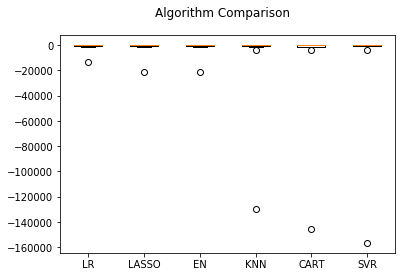

In [414]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [419]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
# pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
# pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))

In [420]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -1733.338451 (3997.668186)
ScaledLASSO: -3879.653883 (10888.413643)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.7157148358674, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71291.46545450157, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80308.20503300102, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklea

ScaledEN: -4328.851397 (12147.118891)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90394.1993711096, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89899.94677662267, tolerance: 1680.5346720772945
  positive)


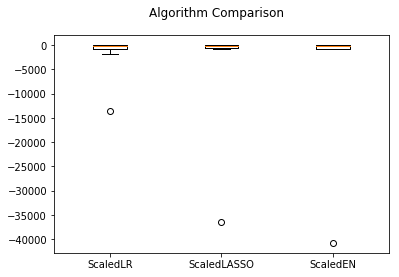

In [421]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Add new columns

In [48]:
test_newstate_df['WhitePop_Density'] = test_newstate_df['WHITE_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['BlackPop_Density'] = test_newstate_df['BLACK_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['WhitePop_Density'] = test_newstate_df['WHITE_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['AmeIndPop_Density'] = test_newstate_df['AMERIND_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['AsianPop_Density'] = test_newstate_df['ASIAN_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['PacificPop_Density'] = test_newstate_df['PACIFIC_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['OtherPop_Density'] = test_newstate_df['OTHRACE_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['HispanicPop_Density'] = test_newstate_df['HISPPOP_CY']/test_newstate_df['TOTPOP_CY']
test_newstate_df['Provider_Density'] = test_newstate_df['Provider_Count']/test_newstate_df['TOTPOP_CY']

In [29]:
# Check Datatypes of different columns
g = test_newstate_df.columns.to_series().groupby(test_newstate_df.dtypes).groups
g

{dtype('int64'): Index(['AAGEBASECY', 'AGGDI_CY', 'AGGHINC_CY', 'AGGINC_CY', 'AGGNW_CY',
        'AIFBASE_CY', 'AIMBASE_CY', 'AMERIND_CY', 'ASIAN_CY', 'ASNFBASECY',
        ...
        'TOTHH_CY', 'TOTHU_CY', 'TOTPOP_CY', 'UNEMP_CY', 'VACANT_CY',
        'WAGEBASECY', 'WHITE_CY', 'WHTFBASECY', 'WHTMBASECY', 'WIDOWED_CY'],
       dtype='object', length=161),
 dtype('float64'): Index(['Provider_Count', 'AREA', 'AVGFMSZ_CY', 'AVGHHSZ_CY', 'LANDAREA',
        'MEDAGE_CY', 'MEDFAGE_CY', 'MEDHHR_CY', 'MEDMAGE_CY', 'POPDENS_CY',
        'UNEMPRT_CY', 'Provider_Density', 'WhitePop_Density',
        'BlackPop_Density', 'AmeIndPop_Density', 'AsianPop_Density',
        'PacificPop_Density', 'OtherPop_Density', 'HispanicPop_Density'],
       dtype='object')}

In [70]:
test_newstate_df.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY,WhitePop_Density,BlackPop_Density,AmeIndPop_Density,AsianPop_Density,PacificPop_Density,OtherPop_Density,HispanicPop_Density,Provider_Density
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462,0.549863,0.058911,0.009413,0.145918,0.003976,0.178414,0.395861,0.000184717
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,114603

## Run Elastic Net

### Using Densities

In [204]:
# Create prdictor and response variables
train_x = test_newstate_df.iloc[:,:20]
train_y = test_newstate_df.iloc[:,-1]
train_x.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140
2,5005.0,1774868,494056143933,721252426439,733561461654,5780147040071,57206,55978,113184,48359.759399,1774868,920657,854211,1234468,65662,3.27,2.59,95857,768205,451725
3,4133.0,585936,487005072197,613723856820,624450149363,6548612367402,40665,42463,83128,56491.338012,585936,316402,269534,1468305,59737,3.03,2.51,75281,803267,282862
4,3210.0,462360,315983343213,411902114464,418518490501,4125980999869,16036,16102,32138,45285.896438,462360,240313,222047,749637,61749,3.02,2.46,80493,806294,236846


In [422]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)
# Transform predictors
# from sklearn.preprocessing import PowerTransformer
# pt_data = PowerTransformer(method='box-cox')
# train_x_pt = pt_data.fit_transform(train_x)

# from scipy.stats import boxcox
# train_x_pt = boxcox(train_x)

In [423]:
# train_x_pt
train_x_std

array([[22.34795477, 18.05516815, 17.965054  , ..., 16.44519452,
        16.80905623, 18.62762542],
       [ 5.6822489 ,  9.64669999,  9.78298609, ...,  9.31051713,
         9.20807555, 11.08252361],
       [ 2.96499875,  4.82089499,  5.87652831, ...,  2.74204776,
         2.58167517,  2.70928177],
       ...,
       [-0.19646359, -0.37685625, -0.37043563, ..., -0.45093924,
        -0.44262892, -0.40747586],
       [-0.19531945, -0.36966815, -0.36346963, ..., -0.41996093,
        -0.41624254, -0.37088673],
       [-0.1937741 , -0.34420822, -0.33565532, ..., -0.3871941 ,
        -0.38137309, -0.34955075]])

#### Tune and Run

Regularization strength is regulated by alpha (similar to lambda in the equation). l1_ratio allows us to vary L1 vs L2 ratio. When the l1_ratio is set to 0 it is the same as ridge regression. When l1_ratio is set to 1 it is lasso.

In [428]:
# Tune hyperparameters for Elastic Net regression

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": [.1, .5, .7, .9, .95, .99, 1]}

eNet = ElasticNet(random_state=3, max_iter=1000)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(train_x_std, train_y)
best_idx = grid.best_index_

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41678.51954203416, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161895.03584090917, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195211.52846741414, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210115.57965929367, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38991.51918803835, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158531.91208379835, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208113.67372772162, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209042.25466932406, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208928.88932987335, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218277.23055833086, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218825.74330476363, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203576.53017394606, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158938.75369887473, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191175.55660511294, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204883.72319995982, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206293.98533976538, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46630.003611657834, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230822.3979823824, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186454.97338264264, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190694.33298899583, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190978.97933677194, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168073.2711810842, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167846.5435118922, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167389.28331844986, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226510.15314598358, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222665.48881026456, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220752.91201737954, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59499.38913881907, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59579.80462290539, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56942.63155557861, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393939.6402163658, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386639.0146009138, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334992.08431829535, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5460.929937050096, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6913.898069663555, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7034.813022656832, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3085.3780808569863, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3110.7923936082516, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaco

In [429]:
print('Best Elastic Net parameters: ' + str(e_gs.best_params_))
print('Best EL cross-validation score: ' + str(e_gs.best_score_))

Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 1}
Best EL cross-validation score: -4144.818911275162


#### Run using parameters from tuning

In [431]:
elastic=ElasticNet(alpha=0.1,l1_ratio=1)
elastic.fit(train_x_std,train_y)

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35780.44715979218, tolerance: 1704.0840955613576
  positive)


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Get Variable Coefficients

In [432]:
coef = pd.Series(elastic.coef_, index = train_x.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 48 variables and eliminated the other 123 variables


In [433]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,train_x.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AAGEBASECY': 0.0,
 'AGGDI_CY': 47.42115457157865,
 'AGGHINC_CY': 87.15589867412909,
 'AGGINC_CY': 3.412823220878211,
 'AGGNW_CY': 0.0,
 'AIFBASE_CY': 0.0,
 'AIMBASE_CY': 0.0,
 'AMERIND_CY': 0.0,
 'AREA': 0.0,
 'ASIAN_CY': 0.0,
 'ASNFBASECY': 0.0,
 'ASNMBASECY': 0.0,
 'ASSCDEG_CY': -2.2187711479879986,
 'AVGDI_CY': 0.0,
 'AVGFMSZ_CY': 1.8384091345091094,
 'AVGHHSZ_CY': 0.0,
 'AVGHINC_CY': 0.0,
 'AVGNW_CY': 1.1031864351227876,
 'AVGVAL_CY': 0.0,
 'BABYBOOMCY': -0.0,
 'BACHDEG_CY': 0.0,
 'BAGEBASECY': 0.0,
 'BLACK_CY': 0.0,
 'BLKFBASECY': 0.0,
 'BLKMBASECY': 0.0,
 'CIVLBFR_CY': -0.0,
 'EDUCBASECY': -0.0,
 'EMP_CY': -0.0,
 'FAMHH_CY': -0.0,
 'FAMPOP_CY': -0.0,
 'FEM0_CY': -13.003996879838455,
 'FEM15_CY': -0.0,
 'FEM18UP_CY': -0.0,
 'FEM20_CY': -6.4407237518483,
 'FEM21UP_CY': -0.0,
 'FEM25_CY': -0.0,
 'FEM30_CY': -0.0,
 'FEM35_CY': -0.0,
 'FEM40_CY': -0.0,
 'FEM45_CY': -0.0,
 'FEM50_CY': -0.0,
 'FEM55_CY': -0.0,
 'FEM5_CY': -0.0,
 'FEM60_CY': -0.0,
 'FEM65_CY': -0.0,
 'FEM70_CY': -0.092

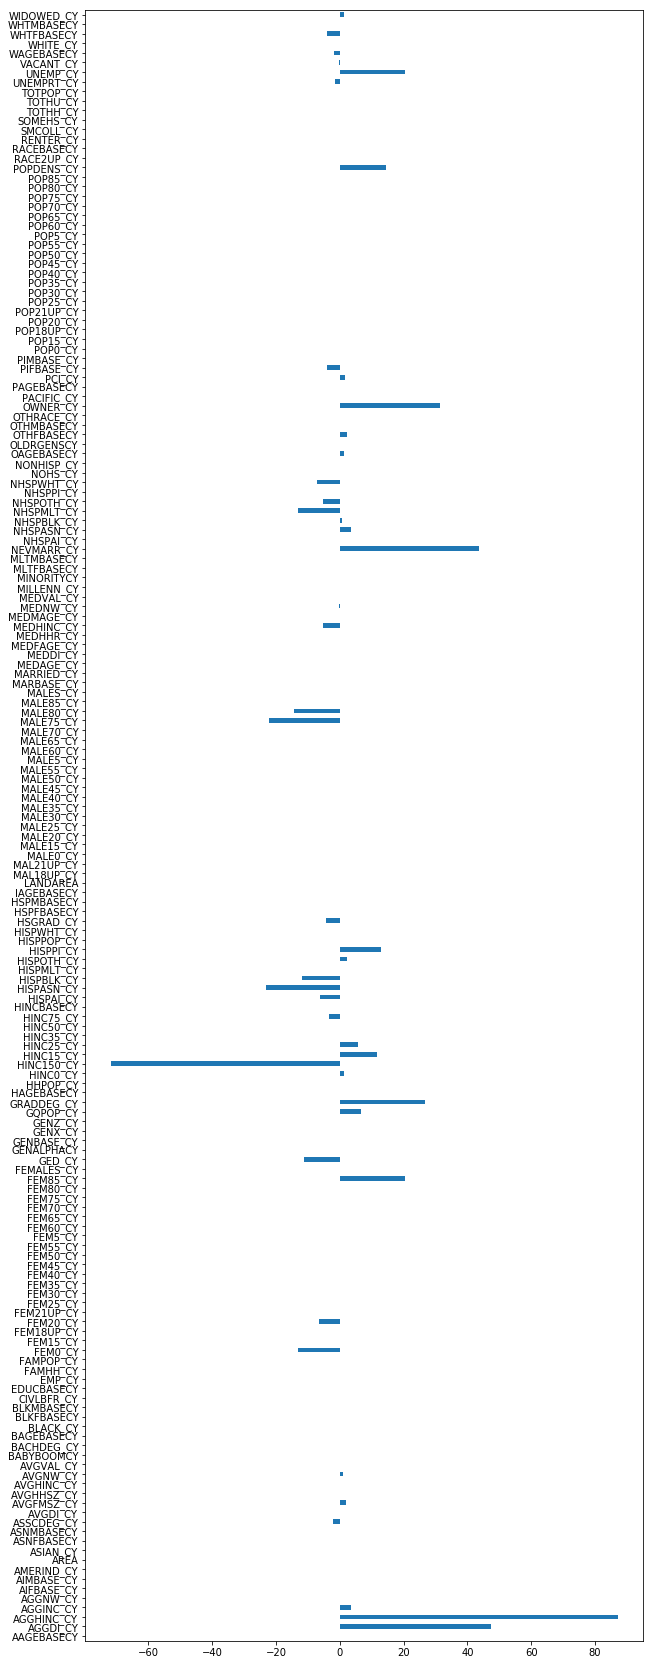

In [434]:
plt.figure(figsize=(10,30))
featureimp = pd.Series(elastic.coef_, index = train_x.columns)
featureimp.plot(kind='barh')
plt.show()

In [ ]:
# Using densities with box-cox
Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
Best EL cross-validation score: -2.5487352278940628e-09

# Not using densities

### Not Using Densities

In [110]:
# Create copy of df to remove density columns
test_newstate_copy = test_newstate_df.iloc[:,:-8]
test_newstate_copy.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,1146033,1057803,1000356,900336,893942,864949,855845,1054854,749300,623922,440199,284583,169339,142828,14358553,22771838,11608584,34.8,48504,35.8,49.5,57286,33.8,89454,173734,7624216,16954978,459123,454026,7616564,92692,1406

In [170]:
# 
train_x_new = test_newstate_copy.iloc[:,1:]
# train_y_new = np.log(test_newstate_df.iloc[:,0].values+1)
train_y_new = test_newstate_df.iloc[:,0]

In [171]:
train_x_new.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462
1,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,1146033,1057803,1000356,900336,893942,864949,855845,1054854,749300,623922,440199,284583,169339,142828,14358553,22771838,11608584,34.8,48504,35.8,49.5,57286,33.8,89454,173734,7624216,16954978,459123,454026,7616564,92692,1406614,3427384,466269,37515,2382

In [172]:
# # Transform predictors
# from sklearn.preprocessing import PowerTransformer
# pt_data = PowerTransformer(method='box-cox')
# train_x_pt = pt_data.fit_transform(train_x_new)

# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x_new)

In [173]:
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": [.1, .5, .7, .9, .95, .99, 1]}

eNet = ElasticNet(random_state=3, max_iter=1000)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(train_x_std, train_y_new)

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20156.070166797137, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25580.82539699177, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36596.932696175005, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27611.69697752278, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30505.919853909458, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28290.68652379256, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26451.98568048466, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26402.902625341812, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29499.46931559191, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53351.77292431351, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50457.35871366033, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60915.047082394005, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\li

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35135.74182869109, tolerance: 10198.469210869565
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29543.79290940451, tolerance: 10062.415610869568
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7186.503147732061, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skle

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78487.06611649539, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127881.2715122926, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136975.0982249205, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41965.66307585173, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43414.320110149194, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42666.3000587859, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369594.9601081552, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342872.256096235, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371066.05115251674, tolerance: 10198.469210869565
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\lin

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172440.25613825218, tolerance: 10062.415610869568
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31015.572063338215, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68407.39152420318, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725458.5199430198, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725983.6848212457, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669429.8122573944, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\lin

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102839.21529204986, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114155.05398217516, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123541.44240985933, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40231.34455722105, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39890.750481483876, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41666.83008177369, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\li

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=3, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [174]:
print('Best Elastic Net parameters: ' + str(grid.best_params_))
print('Best EL cross-validation score: ' + str(grid.best_score_))

Best Elastic Net parameters: {'alpha': 1, 'l1_ratio': 0.5}
Best EL cross-validation score: -35089.43647606921


#### Run using parameters from tuning

In [166]:
elastic=ElasticNet(alpha=0.0001,l1_ratio=0.1)
elastic.fit(train_x_std,train_y)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Get Variable Coefficients

In [168]:
coef = pd.Series(elastic.coef_, index = train_x.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 6 variables and eliminated the other 173 variables


In [167]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,train_x.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'Provider_Count': 0.0,
 'AAGEBASECY': -0.0,
 'AGGDI_CY': 0.0,
 'AGGHINC_CY': 0.0,
 'AGGINC_CY': 0.0,
 'AGGNW_CY': 0.0,
 'AIFBASE_CY': -0.0,
 'AIMBASE_CY': -0.0,
 'AMERIND_CY': -0.0,
 'AREA': -0.0,
 'ASIAN_CY': -0.0,
 'ASNFBASECY': -0.0,
 'ASNMBASECY': -0.0,
 'ASSCDEG_CY': 0.0,
 'AVGDI_CY': 0.0,
 'AVGFMSZ_CY': -0.0,
 'AVGHHSZ_CY': -0.0,
 'AVGHINC_CY': 0.0,
 'AVGNW_CY': 0.0,
 'AVGVAL_CY': 1.3363209295111027e-06,
 'BABYBOOMCY': 0.0,
 'BACHDEG_CY': 0.0,
 'BAGEBASECY': 0.0,
 'BLACK_CY': 0.0,
 'BLKFBASECY': 0.0,
 'BLKMBASECY': 0.0,
 'CIVLBFR_CY': 0.0,
 'EDUCBASECY': 0.0,
 'EMP_CY': 0.0,
 'FAMHH_CY': 0.0,
 'FAMPOP_CY': 0.0,
 'FEM0_CY': -0.0,
 'FEM15_CY': 0.0,
 'FEM18UP_CY': 0.0,
 'FEM20_CY': 0.0,
 'FEM21UP_CY': 0.0,
 'FEM25_CY': 0.0,
 'FEM30_CY': 0.0,
 'FEM35_CY': 0.0,
 'FEM40_CY': 0.0,
 'FEM45_CY': 0.0,
 'FEM50_CY': 0.0,
 'FEM55_CY': 0.0,
 'FEM5_CY': 0.0,
 'FEM60_CY': 0.0,
 'FEM65_CY': 0.0,
 'FEM70_CY': 0.0,
 'FEM75_CY': 0.0,
 'FEM80_CY': 0.0,
 'FEM85_CY': 0.0,
 'FEMALES_CY': 0.0,
 'GED_CY'

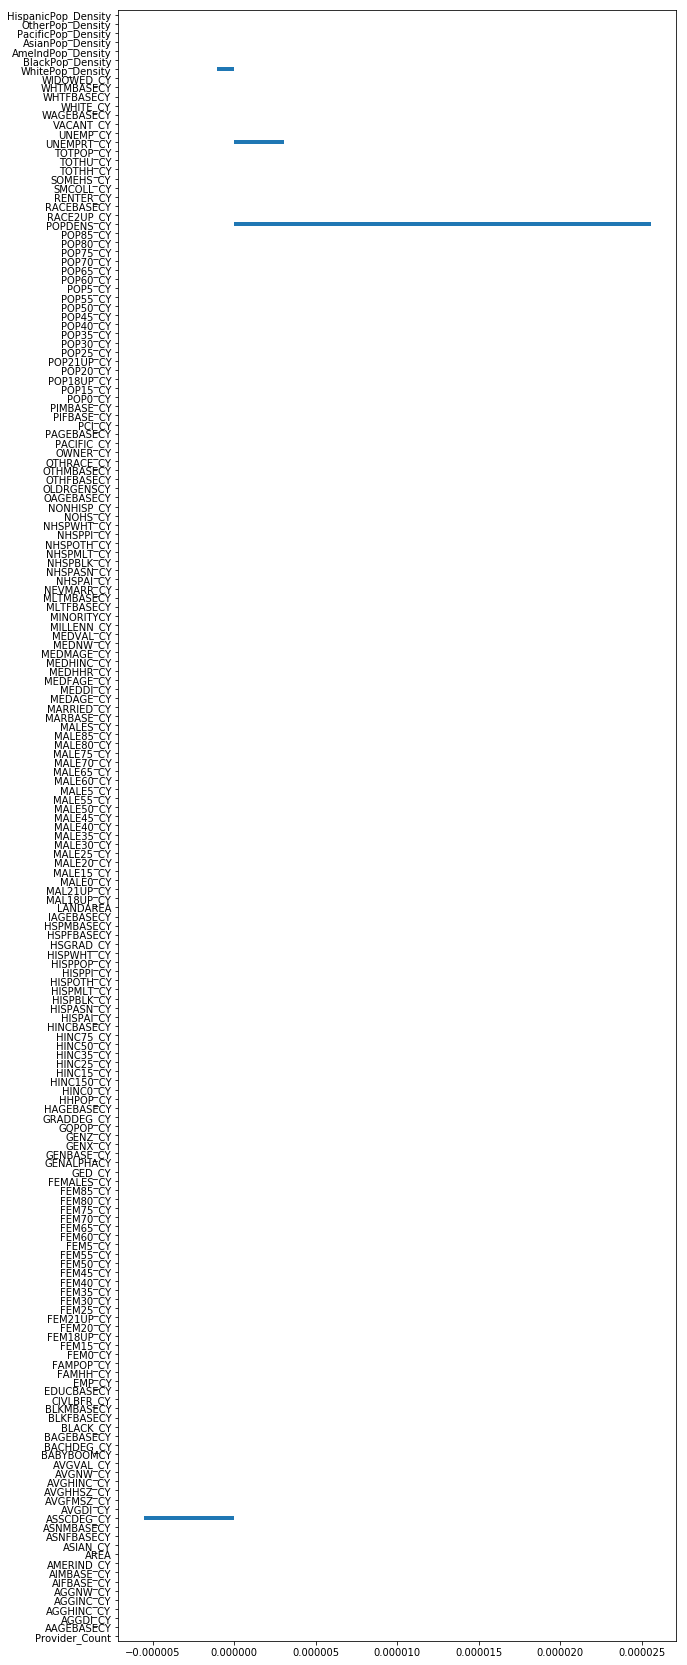

In [157]:
plt.figure(figsize=(10,30))
featureimp = pd.Series(elastic.coef_, index = train_x.columns)
featureimp.plot(kind='barh')
plt.show()